# Capacitively coupled current-biased Josephson junction phase qubits

Robert Johansson (robert@riken.jp)

In [1]:
%pylab inline

In [2]:
from scipy import *
from scipy import optimize

In [3]:
from wavefunction import *

## Problem parameters

In [4]:
h = 6.626e-34
h_ = h/(2*pi)
e = 1.602e-19
Phi0 = h / (2 * e)
cf = 1

H  = 6.626e-34
H_ = H/(2*pi)

Ic = 13.3e-6

#Cj = 4.3e-12

ceta = 0.005
Cj = 4.3e-12
j1 = 0.975

dj2 = 0.001
J2 = arange(0.9701, 0.98, dj2) 

# discretize the x coordinate
xmin = -0.7 * pi
xmax =  4 * pi
N = 750
D = arange(xmin, xmax, (xmax-xmin)/N)

## Potential

In [5]:
def U_current_biased(x, args):
    """
    Potential for a current-biased phase qubit potential
    (the washboard potential)
    """
    Ej = args['Ej']
    Ic = args['Ic']
    Ib = args['Ib']

    u = - Ej * (cos(x) + Ib / Ic * x)

    return u

In [6]:
def jjpq_current_biased_me(ceta, Cj, cf_p, J):

    Ib = J * Ic 
    mm = Cj * (1 + ceta) * (Phi0/(2*pi))**2 * cf
    Ej = Phi0/(2*pi) * Ic / cf
    
    U_args = {'Ej': Ej, 'Ic': Ic, 'Ib': Ib}
    S_param = array([h_, mm])
    
    # Calculate the eigenfunctions
    M = schrodinger_matrix(xmin, xmax, N, S_param, U_current_biased, U_args)
    evals,evec = eigenvectors_sorted(M);
    
    # Find bound states
    dmin = math.asin(Ib/Ic)
    dmax = -math.asin(Ib/Ic) + pi
    delta = dmax-dmin
    
    Umin = U_current_biased(dmin, U_args);
    Umax = U_current_biased(dmax, U_args);
    dU = Umax - Umin;
    
    boundidx = []
    for i in range(0,N):
        if evals[i] > Umin-0.5*dU and evals[i] < Umax+0.5*dU:
            if inner(evec[:,i] * (dmin-delta < D) * (D < dmax), evec[:,i]) > 0.85:
                boundidx.append(i)

    # Evaluate matrix elements:
    inner_prod = zeros((len(boundidx), len(boundidx))).astype(float)
    expect_pos = zeros((len(boundidx), len(boundidx))).astype(float)
    expect_kin = zeros((len(boundidx), len(boundidx))).astype(float)
    energy_levels = zeros(len(boundidx)).astype(float)
    
    for i in range(0, len(boundidx)):
        l = boundidx[i]
        energy_levels[i] = evals[l]
    
        for j in range(0, len(boundidx)):
            k = boundidx[j]
    
            inner_prod[i,j] = inner(evec[:,k], evec[:,l])
            expect_pos[i,j] = inner(evec[:,k], evec[:,l] * D)
            expect_kin[i,j] = inner(evec[:,k], derivative(evec[:,l], D))
    
    return energy_levels, expect_pos, expect_kin

In [7]:
E1, Ed1, Edd1 = jjpq_current_biased_me(ceta, Cj, cf, j1)
P1 = h_ /1j  * Edd1 

eval_idx = 0
eval_store = zeros((len(J2),9)).astype(float)

for j2 in J2:

    E2, Ed2, Edd2 = jjpq_current_biased_me(ceta, Cj, cf, j2);
    P2 = h_ / 1j * Edd2;

    H = zeros((9,9)).astype(float)
    Hint = zeros((9,9)).astype(float)
    
    for K1 in range(0,3):
        for K2 in range(0,3):
            for L1 in range(0,3):
                for L2 in range(0,3):
                    I1 = K1 + 3 * (L1)
                    I2 = K2 + 3 * (L2)
               
                    H[I1,I2] =            (E1[K1] - (1*E1[0]+1*E1[1])/2) * (K1 == K2) * (L1 == L2)
                    H[I1,I2] = H[I1,I2] + (E2[L1] - (1*E2[0]+1*E2[1])/2) * (K1 == K2) * (L1 == L2)
            
                    Hint[I1,I2] = (2*pi / Phi0)**2 * ceta / (Cj * ( 1 + ceta)) * P1[K1,K2] * P2[L1,L2] / cf

    H = H + Hint		
    H = H / (2*pi * 1e9)

    evals, evecs =  eigenvectors_sorted(H)
    eval_store[eval_idx, :] = evals
    eval_idx = eval_idx + 1

-c:25: ComplexWarning: Casting complex values to real discards the imaginary part


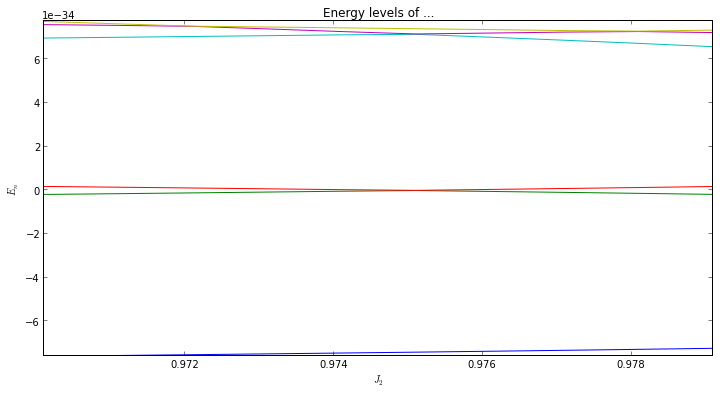

In [8]:
fig, ax = subplots(1, 1, figsize=(12,6))
 
for n in range(6):
    ax.plot(J2, eval_store[:,n])
    
ax.axis('tight');
ax.set_xlabel(r'$J_2$')
ax.set_ylabel(r'$E_n$')
ax.set_title(r'Energy levels of ...')